# Synthetically Generated Data

We test the potential of our estimation algorithm by synthetically generated data.

In [12]:
# std library
import os
import json
from pathlib import Path
from pprint import pprint
from datetime import datetime, timedelta
from typing import Sequence

# third-party
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numpy import typing as npt

# local
from synthetic_data import synthetic_data_simulation  # type: ignore

### 1. Model Setting

In [13]:
# Capacities & Total Innovation Uncertainty
param_theta = 1.0

param_c_i = 1.2
param_c_j = 1.5
param_sigma = 2.0
param_lambda = 1.0
param_r = 15.0

# Contest Time Duaration
start_time = datetime(2025, 1, 1, 0, 0, 0)
end_time = datetime(2025, 4, 1, 0, 0, 0)
contest_days = (end_time - start_time).days
contest_seconds = int((end_time - start_time).total_seconds())
contest_hours = int(contest_seconds / 3600)
contest_timegrids: list[datetime] = np.arange(start_time, end_time, \
		timedelta(hours=1), dtype=datetime).tolist()
time_unit_2f = 1 / 24
print(contest_days, contest_hours, len(contest_timegrids))

#
random_seed = 1000
wd = os.getcwd()
wd_synthetic_data = os.path.join(wd, f'data_{contest_days}_{random_seed}.json')
print(wd_synthetic_data)

90 2160 2160
/Users/linsheng/Documents/GitHub/kaggle-contest-design/synthetic_data/data_90_1000.json


### 2. Simulations

In [14]:
time_grids, i_effort_dynamic, j_effort_dynamic, \
real_gap_dynamic, perceived_gap_dynamic, observed_gap_dynamic, \
observed_i_commits, observed_j_commits = synthetic_data_simulation(
	theta=param_theta,
	c_i=param_c_i,
	c_j=param_c_j,
	sigma=param_sigma,
	lamb=param_lambda,
	intensity_effort_ratio=param_r,
	hour_arrival_ub=1.0,
	start_time=start_time,
	end_time=end_time,
	time_unit=timedelta(hours=1),
	time_unit_2f=time_unit_2f,
	approx = True,  # using approximated version by default
	seed_brownian = random_seed + 0,
	seed_poisson = random_seed + 1,
	seed_uniform = random_seed + 2,
)

In [15]:
# pprint(observed_gap_dynamic)
pprint(f'number of i submissions = {len(observed_i_commits)}')
pprint(f'number of j submissions = {len(observed_j_commits)}')

'number of i submissions = 28'
'number of j submissions = 18'


In [16]:
def plot_ts_events(
		time_grids: Sequence[datetime] | npt.NDArray[np.datetime64],
		ts: dict[str, Sequence | npt.NDArray],
		events: dict[str, Sequence | npt.NDArray],
		ts_colors,
		ts_linestyles,
		*,
		ylim=None,
		figsize=(10, 5),
		height_ratios=[3, 1],
):
	fig, (ax_main, ax_events) = plt.subplots(
		nrows=2, ncols=1, figsize=figsize, height_ratios=height_ratios,
	)
	if ylim is not None:
		ax_main.set_ylim(ylim[0], ylim[1])
	# plot time series
	idx_line = 0
	for ts_key, ts_val in ts.items():
		ax_main.plot(
			time_grids, ts_val, label=ts_key,
			color=ts_colors[idx_line],
			linestyle=ts_linestyles[idx_line],
		)
		idx_line += 1
	ax_main.legend(frameon=False)
	xrange = ax_main.get_xlim()
	# plot events
	event_height = 0.2
	ytick = 0
	yticks = []
	yticklabels = []
	for event_key, event_val in events.items():
		yticks.append(ytick)
		yticklabels.append(event_key)
		ax_events.hlines(y=ytick, xmin=xrange[0], xmax=xrange[1], color='black')
		ax_events.vlines(x=event_val, ymin=ytick - event_height, ymax=ytick + event_height, color='black')
		ytick -= 2.5 * event_height
	ax_events.set_xlim(xrange)
	ax_events.get_xaxis().set_visible(False)
	ax_events.set_yticks(yticks)
	ax_events.set_yticklabels(yticklabels)
	return fig, ax_main, ax_events

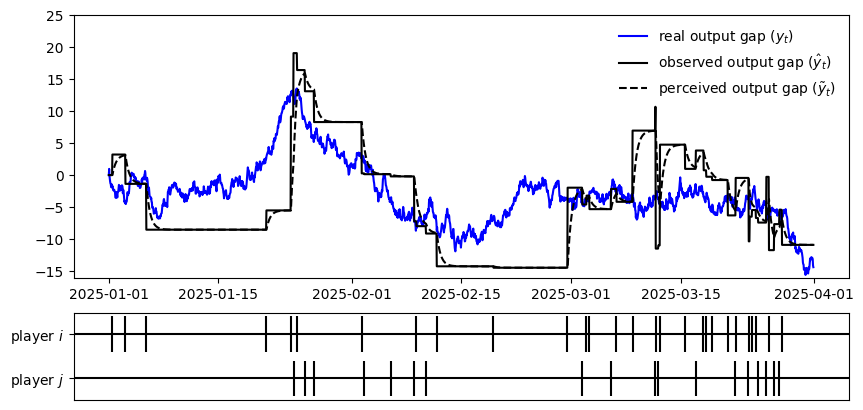

In [17]:
fig, _, _ = plot_ts_events(
		time_grids,
		ts = {
			r'real output gap ($y_t$)': real_gap_dynamic[:-1],
			r'observed output gap ($\hat{y}_t$)': observed_gap_dynamic[:-1],
			r'perceived output gap ($\tilde{y}_t$)': perceived_gap_dynamic[:-1],
		},
		events = {
			r'player $i$': observed_i_commits,
			r'player $j$': observed_j_commits,
		},
		ts_colors=['blue', 'black', 'black'],
		ts_linestyles=['solid', 'solid', 'dashed'],
		ylim = (-16, 25)
	)
fig.savefig("../paper/synthetic_data.pdf", bbox_inches='tight')

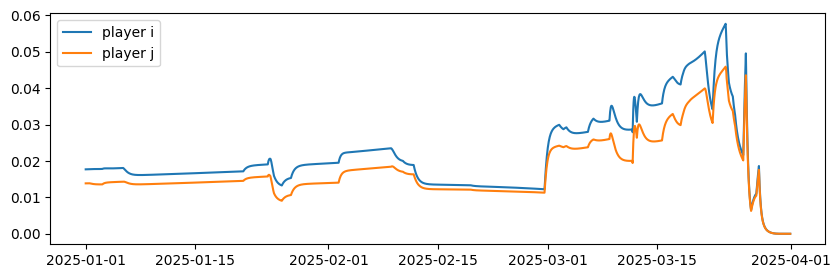

In [18]:
plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), i_effort_dynamic, label='player i')
plt.plot(np.array(time_grids), j_effort_dynamic, label='player j')
plt.legend()
plt.show()

In [19]:
# save the observed data
roundint = lambda x: int(round(x))
data_json = {
		'start_time': time_grids[0].timestamp(),
		'theta': param_theta,
		'ratio': param_r,
		'N_Delta': roundint((end_time - start_time).total_seconds() / 3600),
		'Delta2f': time_unit_2f,
		'Ni': len(observed_i_commits),
		'Nj': len(observed_j_commits),
		'hat_t_i': [(dt - start_time).total_seconds() / 3600 for dt in observed_i_commits],
		'hat_t_j': [(dt - start_time).total_seconds() / 3600 for dt in observed_j_commits],
		'hat_y': observed_gap_dynamic.tolist(),
		'real_y': real_gap_dynamic.tolist(),
	}
with open(wd_synthetic_data, 'w') as f:
	json.dump(data_json, f, indent=4)

### 3. Bayesian Inference

In [20]:
# import cmdstanpy
# cmdstanpy.install_cmdstan()
from cmdstanpy import CmdStanModel, compile_stan_file

In [21]:
# build stan model
stan_file = os.path.join(wd, f'synthetic_data.stan')
output_dir = Path('./tmp')
exe_path = compile_stan_file(
	src=stan_file,
	cpp_options={
		"LDFLAGS": "-headerpad_max_install_names",
		"CXXFLAGS": "-O3",
})
model = CmdStanModel(stan_file=stan_file, exe_file=exe_path)

In [22]:
# fit the model with data
fit = model.sample( \
		data=wd_synthetic_data,
		iter_warmup=1000,
		iter_sampling=2000,
		chains=4,
		parallel_chains=4,
		show_console=False,
		#max_treedepth=12,  # for difficult model
		#adapt_delta=0.99,  # for difficult model
		output_dir=output_dir,
		seed=12345,
	)

11:03:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:04:06 - cmdstanpy - INFO - CmdStan done processing.
11:04:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'synthetic_data.stan', line 81, column 2 to column 53) (in 'synthetic_data.stan', line 176, column 2 to line 181, column 4)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'synthetic_data.stan', line 81, column 2 to column 53) (in 'synthetic_data.stan', line 176, column 2 to line 181, column 4)
Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'synthetic_data.stan', line 81, column 2 to column 53) (in 'synthetic_data.stan', line 176, column 2 to line 181, column 4)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'synthetic_data.stan', line 81, column 2 to column 53) (in 'synthetic_data.stan', line 176, column 2 to line 181, column 4)
	Exception: Exception: normal_lpdf: Random va

In [23]:
# pprint(fit.diagnose())

In [24]:
posteriors = fit.stan_variables()

In [25]:
def rmse(true, mean, std):
	return ((true - mean)**2 + std**2)**0.5

def display_estimation_results(var_names: list[str], true_vals, posteriors):
	data = []
	for name, true_val in zip(var_names, true_vals):
		posterior_mean = posteriors[name].mean()
		posterior_std = posteriors[name].std()
		quantile_05, quantile_95 = np.percentile(posteriors[name], [2.5, 97.5])
		record = (
			name, true_val, posterior_mean, posterior_std,
			rmse(true_val, posterior_mean, posterior_std),
			quantile_05, quantile_95
		)
		data.append(record)
	columns = ['Name', 'True Val.', 'Posterior Mean', 'Posterior Std.', 'RMSE',
			'2.5% Quantile', '97.5% Quantile']
	return pd.DataFrame(data, columns=columns)

In [26]:
display_estimation_results(
	['c_i', 'c_j', 'sigma', 'lambda', 'mu_0'],
	[param_c_i, param_c_j, param_sigma, param_lambda, 0],
	posteriors
)

,Name,True Val.,Posterior Mean,Posterior Std.,RMSE,2.5% Quantile,97.5% Quantile
0,c_i,1.2,1.097569,0.256168,0.275888,0.684523,1.683954
1,c_j,1.5,1.743864,0.482010,0.540188,1.009659,2.901108
2,sigma,2.0,2.791885,0.501404,0.937277,1.950479,3.938062
3,lambda,1.0,1.106425,0.298687,0.317080,0.616592,1.789212
4,mu_0,0.0,-0.012493,0.995739,0.995817,-1.962203,1.900418


Compare posterior `m[1]..m[T]` with real:

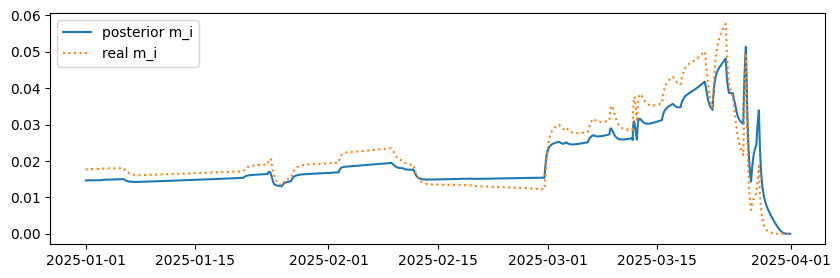

-3.521440075149772


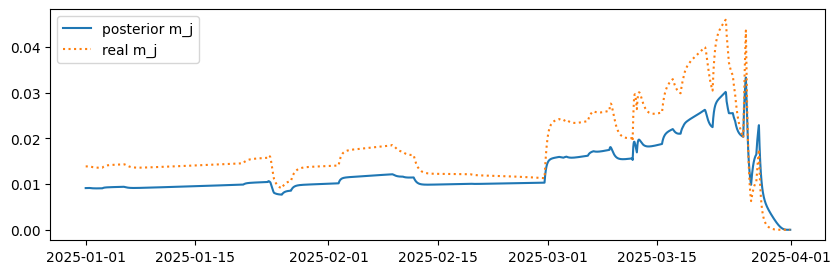

-10.502276946486738


In [27]:
posterior_m_i_mean = fit.stan_variable('m_i').mean(axis=0)
posterior_m_j_mean = fit.stan_variable('m_j').mean(axis=0)

plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), posterior_m_i_mean, label='posterior m_i')
plt.plot(np.array(time_grids), i_effort_dynamic, label='real m_i', linestyle='dotted')
plt.legend()
plt.show()
print(np.sum(posterior_m_i_mean - i_effort_dynamic))

plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), posterior_m_j_mean, label='posterior m_j')
plt.plot(np.array(time_grids), j_effort_dynamic, label='real m_j', linestyle='dotted')
plt.legend()
plt.show()
print(np.sum(posterior_m_j_mean - j_effort_dynamic))

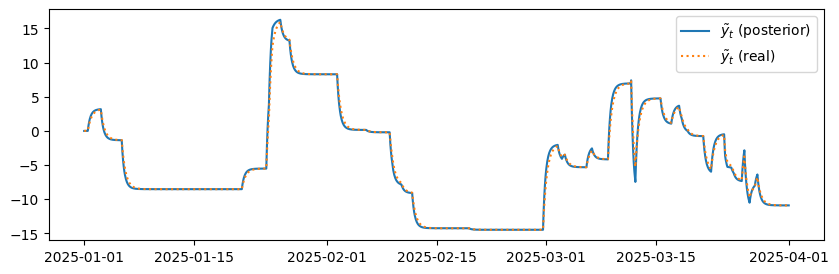

-34.64156515781201


In [28]:
## compare posterior \tilde{y}[1]..\tilde{y}[T] with real

posterior_tilde_y_mean = fit.stan_variable('tilde_y').mean(axis=0)

plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), posterior_tilde_y_mean[:-1], label=r'$\tilde{y}_t$ (posterior)')
plt.plot(np.array(time_grids), perceived_gap_dynamic[:-1], label=r'$\tilde{y}_t$ (real)', linestyle='dotted')
plt.legend()
plt.show()
print(np.sum(posterior_tilde_y_mean - perceived_gap_dynamic))

### Clean Up

In [29]:
for file in output_dir.iterdir():
	if file.is_file():
		file.unlink()

### KDE & MLE

#### (1) KDE

In [30]:
from scipy.stats import gaussian_kde

def estimate_effort_kde(contest_data_json):
	"""Using kernel density estimation to estimate submisison intensity

	Return: intensity per hour
	"""
	N_Delta = contest_data_json['N_Delta']
	time_grids_f = [i for i in range(N_Delta)]  # float
	hat_t_i_f = np.array(contest_data_json['hat_t_i'])
	hat_t_j_f = np.array(contest_data_json['hat_t_j'])

	kde_i = gaussian_kde(hat_t_i_f, bw_method=1.0)
	kde_j = gaussian_kde(hat_t_j_f, bw_method=1.0)
	density_i = kde_i(time_grids_f)
	density_j = kde_j(time_grids_f)
	intensity_i = density_i * len(hat_t_i_f)
	intensity_j = density_j * len(hat_t_j_f)

	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	time_grids = [start_time + timedelta(hours=i) for i in time_grids_f]
	hat_t_i = [start_time + timedelta(hours=t) for t in hat_t_i_f]
	hat_t_j = [start_time + timedelta(hours=t) for t in hat_t_j_f]
	return time_grids, hat_t_i, intensity_i, hat_t_j, intensity_j

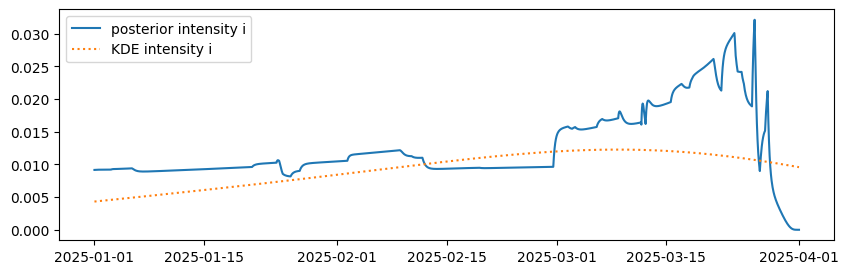

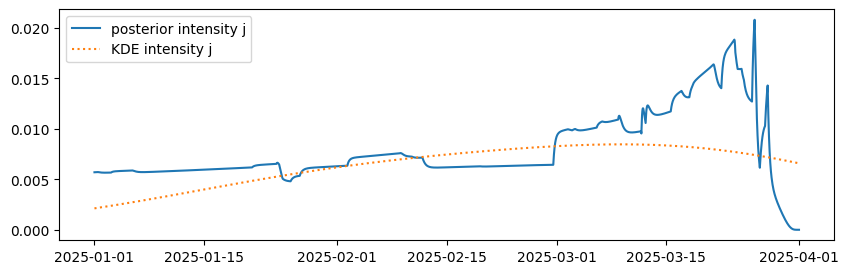

In [31]:
# KDE
time_grids, hat_t_i, intensity_i, hat_t_j, intensity_j = estimate_effort_kde(data_json)

plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), posterior_m_i_mean * param_r / 24, label='posterior intensity i')
plt.plot(np.array(time_grids), intensity_i, label='KDE intensity i', linestyle='dotted')
plt.legend()
plt.show()
plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), posterior_m_j_mean * param_r / 24, label='posterior intensity j')
plt.plot(np.array(time_grids), intensity_j, label='KDE intensity j', linestyle='dotted')
plt.legend()
plt.show()

#### (2) MLE

In [32]:
def contest_sigma_mle(contest_data_json, r_hat):
	# KDE
	time_grids, hat_t_i, intensity_i, hat_t_j, intensity_j = estimate_effort_kde(contest_data_json)
	arr_real_y = contest_data_json['real_y']
	Delta2f = contest_data_json['Delta2f']

	# departion
	N = n_i = n_j = 0
	arr_tk = []
	arr_y_tk = []
	arr_sum_intensity_gap = []
	sum_intensity_gap = 0
	for t, y, tau_i, tau_j in zip(time_grids, arr_real_y, intensity_i, intensity_j):
		sum_intensity_gap += tau_i - tau_j
		if n_i < len(hat_t_i) and t - timedelta(hours=1) < hat_t_i[n_i] < t:
			if len(arr_tk) > 0 and hat_t_i[n_i] <= arr_tk[-1]:
				n_i += 1
				continue
			arr_tk.append(hat_t_i[n_i])
			arr_y_tk.append(y)
			arr_sum_intensity_gap.append(24 * sum_intensity_gap * Delta2f)
			sum_intensity_gap = 0
			n_i += 1
			N += 1
		if n_j < len(hat_t_j) and t - timedelta(hours=1) < hat_t_j[n_j] < t:
			if len(arr_tk) > 0 and hat_t_j[n_j] <= arr_tk[-1]:
				n_j += 1
				continue
			arr_tk.append(hat_t_j[n_j])
			arr_y_tk.append(y)
			arr_sum_intensity_gap.append(24 * sum_intensity_gap * Delta2f)
			sum_intensity_gap = 0
			n_j += 1
			N += 1
	arr_sum_intensity_gap = arr_sum_intensity_gap[1:]  # drop the first

	# MLE
	arr_delta_tk = [(arr_tk[ii + 1] - arr_tk[ii]).total_seconds() / 3600 * Delta2f for ii in range(N - 1)]
	arr_delta_y_tk = [arr_y_tk[ii + 1] - arr_y_tk[ii] for ii in range(N - 1)]

	zip_3 = list(zip(arr_delta_y_tk, arr_sum_intensity_gap, arr_delta_tk))
	mle_sigma_squared = np.mean([(Xk - Mk / r_hat)**2 / Tk for Xk, Mk, Tk in zip_3])
	return mle_sigma_squared**0.5

In [33]:
mle_sigma = contest_sigma_mle(data_json, param_r)
mle_sigma

np.float64(1.8007543796385315)